<a href="https://colab.research.google.com/github/IT22232236/fake-news-detection/blob/feat%2FmemberB-eda/notebooks/02_memberB_eda_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git config --global user.email "indrachapavithanage306@gmail.com"
!git config --global user.name "SandaminiI"

In [2]:
REPO = "fake-news-detection"
OWNER = "IT22232236"       # repo owner’s username (yours)
TOKEN = "token"

!git clone https://{TOKEN}@github.com/{OWNER}/{REPO}.git
%cd /content/{REPO}


Cloning into 'fake-news-detection'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (10/10), done.
Receiving objects: 100% (14/14), 18.46 KiB | 3.69 MiB/s, done.
remote: Total 14 (delta 2), reused 8 (delta 0), pack-reused 0 (from 0)
Resolving deltas: 100% (2/2), done.
/content/fake-news-detection


In [3]:
BRANCH = "feat/memberB-eda"
!git checkout -b {BRANCH}

Switched to a new branch 'feat/memberB-eda'


In [4]:
import os, pathlib
os.makedirs("data/processed", exist_ok=True)
os.makedirs("results/figs", exist_ok=True)
!ls -lah data/processed


total 8.0K
drwxr-xr-x 2 root root 4.0K Oct  8 07:22 .
drwxr-xr-x 3 root root 4.0K Oct  8 07:22 ..


In [6]:
from google.colab import files
uploaded = files.upload()    # choose train.csv, val.csv, test.csv

Saving train.csv to train.csv
Saving test.csv to test.csv
Saving val.csv to val.csv


In [7]:
import os
os.makedirs("data/processed", exist_ok=True)
!mv train.csv data/processed/train.csv
!mv val.csv data/processed/val.csv
!mv test.csv data/processed/test.csv
!ls data/processed

test.csv  train.csv  val.csv


In [8]:
train = pd.read_csv("data/processed/train.csv")
val   = pd.read_csv("data/processed/val.csv")
test  = pd.read_csv("data/processed/test.csv")

In [9]:
assert {'text_clean','label'}.issubset(train.columns), "Expected columns: text_clean, label"
train.head()

,text_clean,label
0,kenya police shoot dead two opposition protest...,0
1,angry cruz kicks young boy rally disruptive su...,1
2,region must pressure south sudan leaders end c...,0
3,names revealed top donor popular actress behin...,1
4,holy moly rebel media uncovers illegal usa can...,1


Shapes → train: (37554, 2)  val: (4489, 3)  test: (4489, 3)

Label distribution (train):
label
real    0.5
fake    0.5
Name: proportion, dtype: float64


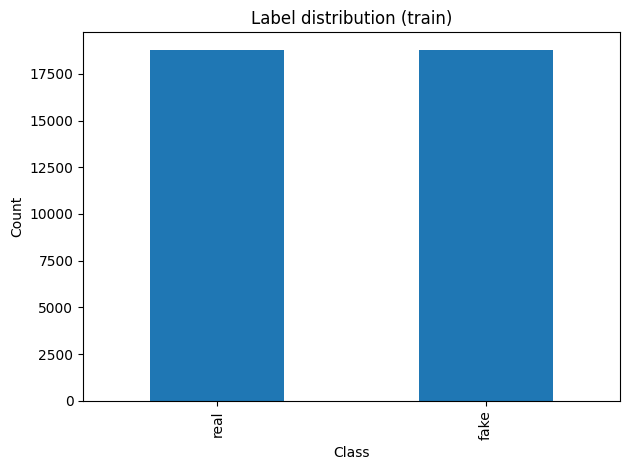

In [10]:
print("Shapes → train:", train.shape, " val:", val.shape, " test:", test.shape)
print("\nLabel distribution (train):")
print(train['label'].value_counts(normalize=True).rename({0:'real',1:'fake'}))

# Save a bar chart of label distribution
ax = train['label'].replace({0:'real',1:'fake'}).value_counts().plot(kind='bar')
plt.title('Label distribution (train)')
plt.xlabel('Class'); plt.ylabel('Count')
plt.tight_layout()
plt.savefig('results/figs/label_dist_train.png'); plt.show()


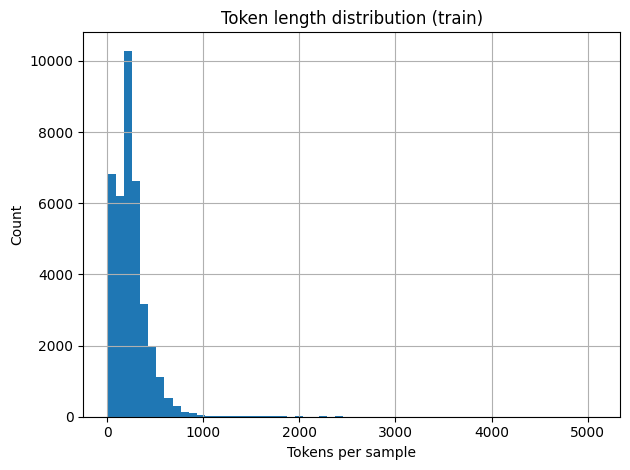

Length stats: count    37554.000000
mean       248.903712
std        207.836074
min          4.000000
50%        221.000000
90%        454.000000
95%        553.350000
99%        879.470000
max       5083.000000
Name: len, dtype: float64


In [11]:
train['len'] = train['text_clean'].str.split().apply(len)

# Histogram (token lengths)
train['len'].hist(bins=60)
plt.title('Token length distribution (train)')
plt.xlabel('Tokens per sample'); plt.ylabel('Count')
plt.tight_layout()
plt.savefig('results/figs/len_hist_train.png'); plt.show()

print("Length stats:", train['len'].describe(percentiles=[.5,.9,.95,.99]))


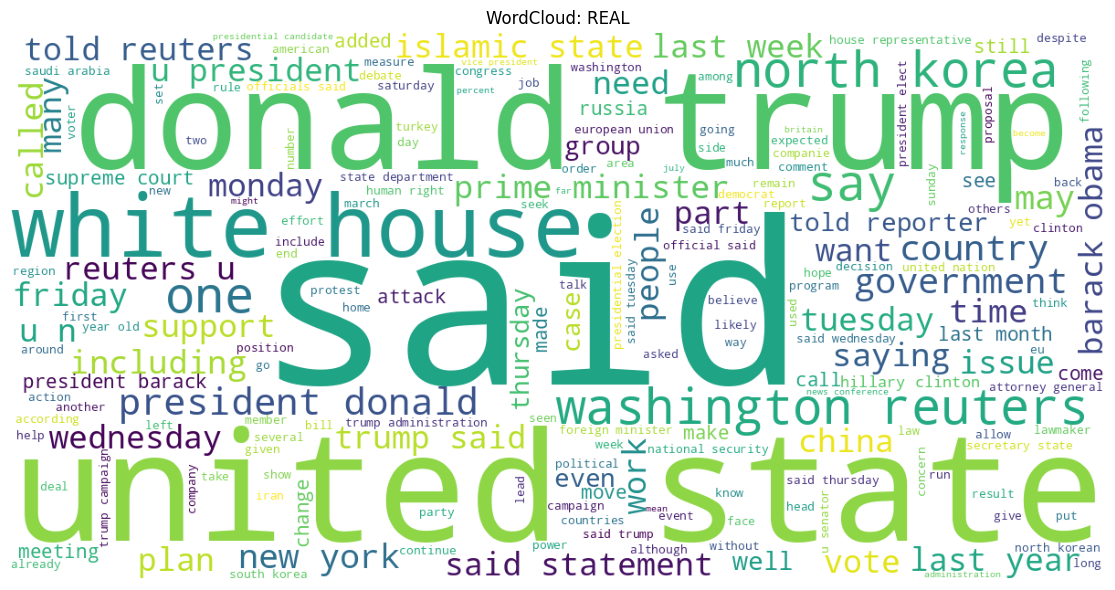

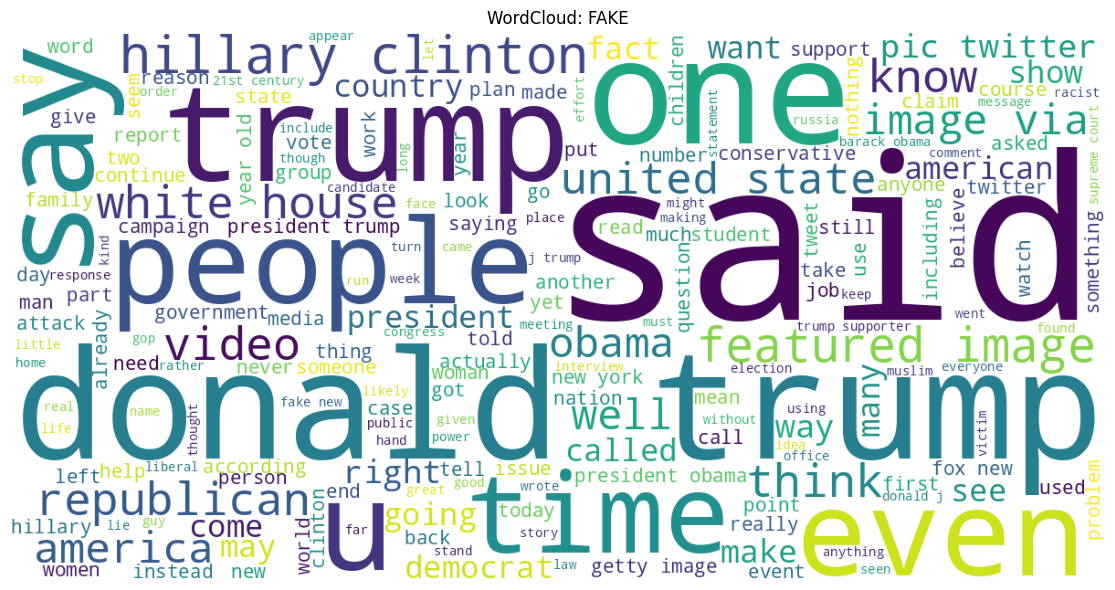

In [12]:
def plot_wc(texts, title, outfile):
    txt = " ".join(texts.tolist())
    wc = WordCloud(width=1200, height=600, background_color='white').generate(txt)
    plt.figure(figsize=(12,6))
    plt.imshow(wc); plt.axis('off'); plt.title(title)
    plt.tight_layout()
    plt.savefig(outfile); plt.show()

plot_wc(train[train['label']==0]['text_clean'], "WordCloud: REAL", 'results/figs/wc_real.png')
plot_wc(train[train['label']==1]['text_clean'], "WordCloud: FAKE", 'results/figs/wc_fake.png')


Top unigrams: [('trump', np.int64(123767)), ('said', np.int64(113684)), ('president', np.int64(48389)), ('would', np.int64(46874)), ('people', np.int64(35240)), ('one', np.int64(32025)), ('state', np.int64(29943)), ('new', np.int64(27874)), ('also', np.int64(26329)), ('obama', np.int64(26023))]
Top bigrams: [('donald trump', np.int64(22665)), ('united states', np.int64(16065)), ('white house', np.int64(13643)), ('hillary clinton', np.int64(8445)), ('new york', np.int64(7812)), ('north korea', np.int64(6362)), ('featured image', np.int64(6110)), ('president donald', np.int64(6065)), ('washington reuters', np.int64(5840)), ('image via', np.int64(5066))]
Top trigrams: [('president donald trump', np.int64(6005)), ('pic twitter com', np.int64(4885)), ('featured image via', np.int64(4516)), ('president barack obama', np.int64(3361)), ('new york times', np.int64(1752)), ('21st century wire', np.int64(1534)), ('donald trump realdonaldtrump', np.int64(1440)), ('reuters president donald', np.int

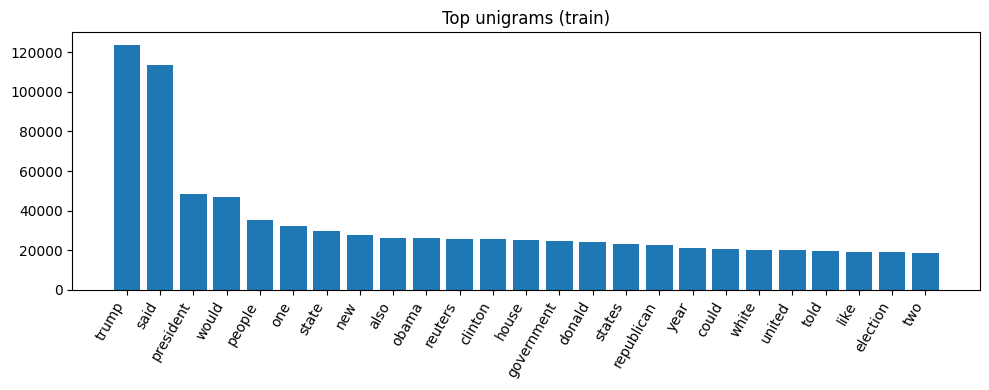

In [13]:
def top_ngrams(texts, ngram=(1,1), topk=25, min_df=5):
    vec = CountVectorizer(ngram_range=ngram, min_df=min_df).fit(texts)
    bag = vec.transform(texts)
    sums = np.asarray(bag.sum(axis=0)).ravel()
    idx = np.argsort(-sums)[:topk]
    vocab = np.array(vec.get_feature_names_out())
    return list(zip(vocab[idx], sums[idx]))

uni = top_ngrams(train['text_clean'], (1,1), 25, 5)
bi  = top_ngrams(train['text_clean'], (2,2), 25, 5)
tri = top_ngrams(train['text_clean'], (3,3), 15, 5)

print("Top unigrams:", uni[:10])
print("Top bigrams:", bi[:10])
print("Top trigrams:", tri[:10])

# Save top unigrams as a simple bar plot
labels, counts = zip(*uni)
plt.figure(figsize=(10,4))
plt.bar(range(len(labels)), counts)
plt.xticks(range(len(labels)), labels, rotation=60, ha='right')
plt.title('Top unigrams (train)')
plt.tight_layout()
plt.savefig('results/figs/top_unigrams.png'); plt.show()


In [14]:
summary = {
    "n_train": len(train),
    "n_val": len(val),
    "n_test": len(test),
    "pos_ratio_train": float((train['label']==1).mean()),
    "median_len": int(train['len'].median()),
    "p90_len": int(train['len'].quantile(0.90)),
}
pd.DataFrame([summary])


,n_train,n_val,n_test,pos_ratio_train,median_len,p90_len
0,37554,4489,4489,0.5,221,454


In [15]:
summary_df = pd.DataFrame([summary])
summary_df.to_csv('results/eda_summary.csv', index=False)
print("Saved: results/eda_summary.csv")

Saved: results/eda_summary.csv


In [21]:
!git add -f results/eda_summary.csv \
results/figs/label_dist_train.png \
results/figs/len_hist_train.png \
results/figs/top_unigrams.png \
results/figs/wc_real.png \
results/figs/wc_fake.png

!git commit -m "Member B –  add of summary & figures"
!git push --set-upstream origin feat/memberB-eda


[feat/memberB-eda aa7712b] Member B –  add of summary & figures
 6 files changed, 2 insertions(+)
 create mode 100644 results/eda_summary.csv
 create mode 100644 results/figs/label_dist_train.png
 create mode 100644 results/figs/len_hist_train.png
 create mode 100644 results/figs/top_unigrams.png
 create mode 100644 results/figs/wc_fake.png
 create mode 100644 results/figs/wc_real.png
Enumerating objects: 12, done.
Counting objects: 100% (12/12), done.
Delta compression using up to 2 threads
Compressing objects: 100% (10/10), done.
Writing objects: 100% (10/10), 948.16 KiB | 12.48 MiB/s, done.
Total 10 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
remote: 
remote: Create a pull request for 'feat/memberB-eda' on GitHub by visiting:
remote:      https://github.com/IT22232236/fake-news-detection/pull/new/feat/memberB-eda
remote: 
To https://github.com/IT22232236/fake-news-detection.git
 * [new branch]      feat/memberB-ed